In [1]:
%cd ..
%pwd
import torch_geometric
import torch
import networkx as nx
from networkx import DiGraph
from typing import Optional, List, Any, Tuple
from torch_geometric.utils.convert import from_networkx
from heapq import heapify
import random
import torch.nn as nn
import wandb

/home/tekne/Oxford/ATML/Project/ggs-nn-model


In [2]:
wandb.init(project='ggnn_heaps')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tekne (use `wandb login --relogin` to force relogin)
/home/tekne/.local/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [3]:
def parent(i: int) -> Optional[int]:
    if i <= 0:
        return None
    return (i - 1) // 2

def is_heap(l) -> bool:
    for (i, e) in enumerate(l):
        p = parent(i)
        if p is not None and l[p] > e:
            return False
    return True

In [4]:
TOKEN_DIM = 1
MAX_LEN = 32

In [5]:
def make_array(min_len: int = 1, max_len: int = MAX_LEN, p_heapify: float = 0.4) -> Tuple[List[int], bool]:
    result = []
    n = random.randint(min_len, max_len)
    for i in range(0, n):
        result.append(random.random())
    if random.random() < p_heapify: 
        heapify(result)
        result_is_heap = True
    else:
        result_is_heap = is_heap(result)
    return (torch.tensor(result).view(n, -1), result_is_heap)

In [6]:
for i in range(0, 5):
    arr = make_array()
    print(f"Example {i} has shape {tuple(arr[0].shape)} and {'is' if arr[1] else 'is not'} a heap")

Example 0 has shape (14, 1) and is a heap
Example 1 has shape (16, 1) and is not a heap
Example 2 has shape (25, 1) and is a heap
Example 3 has shape (2, 1) and is a heap
Example 4 has shape (29, 1) and is a heap


In [7]:
def is_heapgraph(graph):
    for n, nbrs in graph.adj.items():
        for nbr in nbrs:
            if parent(nbr) != n:
                return False
    return True


def heapgraph(n: int) -> DiGraph:
    result = DiGraph()
    result.add_nodes_from(range(0, n))
    result.add_edges_from(
        (parent(i), i) for i in range(0, n) if parent(i) is not None
    )
    assert is_heapgraph(result)
    return result

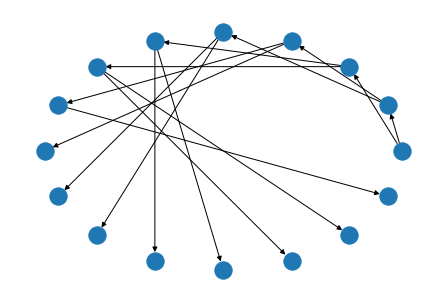

In [8]:
import matplotlib.pyplot as plt
nx.draw_circular(heapgraph(16))

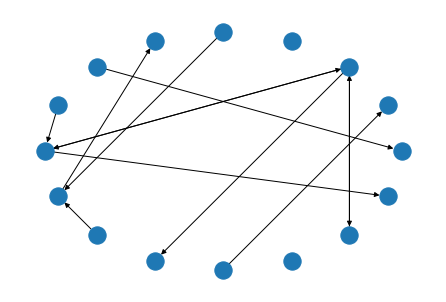

In [9]:
nx.draw_circular(nx.erdos_renyi_graph(16, 1/17, directed=True))

In [10]:
def make_datapoint(min_len: int = 1, max_len: int = MAX_LEN, p_heapify: float = 0.75, p_heap_graph: float = 0.75, and_y: bool = True) -> List[int]:
    (nodes, is_heap) = make_array(min_len, max_len, p_heapify)
    n = nodes.shape[0]
    if random.random() < p_heap_graph: 
        graph = heapgraph(n)
        is_hg = True
    else:
        graph = nx.erdos_renyi_graph(n, 1/(n + 1), directed=True)
        is_hg = is_heapgraph(graph)
    
    data = from_networkx(graph)
    
    # Dumb edge case for when the number of edges is 0. Open an issue for torch_geometric?
    if data.edge_index.dtype != torch.long:
        data.edge_index = torch.zeros((2, 0), dtype=torch.long)

    assert data.edge_index.dtype == torch.long

    data.x = nodes
    if and_y:
        data.y = torch.tensor([float(is_heap and is_hg)])
    else:
        data.y = torch.tensor([
            float(is_heap),
            float(is_hg)
        ])

    return data

In [11]:
data = make_datapoint()
data

Data(edge_index=[2, 28], x=[29, 1], y=[1])

In [12]:
def generate_data(n: int, min_len: int = 1, max_len: int = MAX_LEN, p_heapify: float = 0.75, p_heap_graph: float = 0.75):
    for _ in range(0, n):
        yield make_datapoint(min_len=min_len, max_len=max_len, p_heapify=p_heapify, p_heap_graph=p_heap_graph)

In [13]:
list(generate_data(10))

[Data(edge_index=[2, 21], x=[22, 1], y=[1]),
 Data(edge_index=[2, 10], x=[10, 1], y=[1]),
 Data(edge_index=[2, 27], x=[28, 1], y=[1]),
 Data(edge_index=[2, 29], x=[30, 1], y=[1]),
 Data(edge_index=[2, 5], x=[6, 1], y=[1]),
 Data(edge_index=[2, 7], x=[8, 1], y=[1]),
 Data(edge_index=[2, 23], x=[24, 1], y=[1]),
 Data(edge_index=[2, 14], x=[17, 1], y=[1]),
 Data(edge_index=[2, 21], x=[22, 1], y=[1]),
 Data(edge_index=[2, 2], x=[3, 1], y=[1])]

# Experiment 1:

Generate mixed heap and non-heap graphs, and heap and non-heap data. Attempt to distinguish whether something is both a heap-graph *and* has heap-data. Nodes are *not* shuffled, but batching is used.

In [14]:
BATCH_SIZE = 1000

config = wandb.config
config.epochs = 400
config.batch_size = BATCH_SIZE
config.learning_rate = 0.001
config.n_samples = 1000
config.test_samples = 1000

training_data = list(generate_data(wandb.config.n_samples))
testing_data = list(generate_data(wandb.config.test_samples))

training_loader = torch_geometric.data.DataLoader(training_data, batch_size=BATCH_SIZE)
testing_loader = torch_geometric.data.DataLoader(testing_data, batch_size=BATCH_SIZE)

In [15]:
for i in range(0, 10):
    print(f"{training_data[i]} ==> {training_data[i].y}")

Data(edge_index=[2, 12], x=[13, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 7], x=[8, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 15], x=[23, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 7], x=[7, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 7], x=[8, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 8], x=[9, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 29], x=[24, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 16], x=[17, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 3], x=[4, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 5], x=[12, 1], y=[1]) ==> tensor([0.])


In [16]:
from ggnns.graph_level_ggnn import GraphLevelGGNN
from ggnns.cycle_data import *

In [17]:
HIDDEN_SIZE = 10
NUM_LAYERS = 3
wandb.config.hidden_size = HIDDEN_SIZE
wandb.config.num_layers = NUM_LAYERS

ggnn = GraphLevelGGNN(
    annotation_size=TOKEN_DIM,
    num_layers=NUM_LAYERS,
    gate_nn=nn.Linear(2*TOKEN_DIM + HIDDEN_SIZE, 1),
    hidden_size=HIDDEN_SIZE,
    final_layer=nn.Linear(2*TOKEN_DIM + HIDDEN_SIZE, 1)
).cuda()

wandb.watch(ggnn)

In [18]:
optimizer = torch.optim.Adam(ggnn.parameters(), lr=wandb.config.learning_rate)
criterion = nn.MSELoss()

In [19]:
ggnn.train()
epoch_losses = []
epoch_accs = []
batch_losses = []
test_losses = []
test_accs = []
for epoch in trange(0, config.epochs):

    epoch_loss = 0.0
    count = 0
    epoch_correct = 0
    epoch_total = 0
    for data in training_loader:
        out = ggnn(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        y = data.y.cuda()
        correct = ((out.view(-1) >= 0.5) == y).sum()
        epoch_correct += correct
        total = y.view(-1).shape[-1]
        epoch_total += total
        loss = criterion(out.view(-1), y)
        loss.backward()
        wandb.log(
            {"loss": loss, "accuracy": correct/total}
        )
        batch_losses.append(float(loss))
        epoch_loss += float(loss)
        count += 1
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss /= count
    epoch_losses.append(epoch_loss)
    epoch_accuracy = epoch_correct / epoch_total
    epoch_accs.append(int(correct) / total)
    wandb.log(
        {"epoch_loss": epoch_loss, "epoch_accuracy": epoch_accuracy}
    )

    test_loss = 0.0
    count = 0
    test_correct = 0
    test_total = 0
    for data in testing_loader:
        out = ggnn(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        y = data.y.cuda()
        loss = criterion(out.view(-1), y)
        correct = ((out.view(-1) >= 0.5) == y).sum()
        test_correct += correct
        total = y.view(-1).shape[-1]
        test_total += total
        count += 1
        test_loss += float(loss)

    test_loss /= count
    test_losses.append(test_loss)
    test_accuracy = test_correct / test_total
    test_accs.append(test_accuracy)
    wandb.log(
        {"test_loss": test_loss, "test_accuracy": test_accuracy}
    )

100%|██████████| 400/400 [00:29<00:00, 13.57it/s]


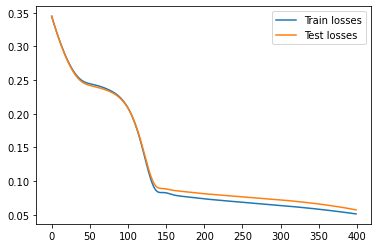

In [20]:
plt.plot(epoch_losses, label="Train losses")
plt.plot(test_losses, label="Test losses")
plt.legend()

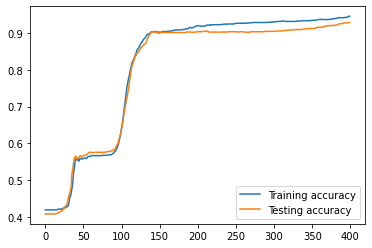

In [21]:
plt.plot(epoch_accs, label="Training accuracy")
plt.plot(test_accs, label="Testing accuracy")
plt.legend()

In [40]:
test_accs[-1]

0.952